In [9]:
import matplotlib.pyplot as plt

from Ballot import Ballot
from DefaultConfigOptions import *
from PartyPrimaryElection import PartyPrimaryElection
from ElectionResult import ElectionResult
from DistrictData import DistrictVotingRecord, DistrictData
from InstantRunoffElection import InstantRunoffElection
from HeadToHeadElection import HeadToHeadElection
from Population import Population
from NDPopulation import NDPopulation
from typing import List, Set, Callable
from Election import Election

In [10]:


class ElectionConstructor:
    def __init__(self, constructor: Callable[[List[Ballot], Set[Candidate]], Election], name: str):
        self.constructor = constructor
        self.name = name

    def run(self, ballots: List[Ballot], candidates: Set[Candidate]) -> ElectionResult:
        e = self.constructor(ballots, candidates)
        return e.result()


def construct_irv(ballots: List[Ballot], candidates: Set[Candidate]):
    return InstantRunoffElection(ballots, candidates)


def construct_h2h(ballots: List[Ballot], candidates: Set[Candidate]):
    return HeadToHeadElection(ballots, candidates)



In [11]:
def run_election(dvr: DistrictVotingRecord,
                 processes: List[ElectionConstructor],
                 dec: ElectionConfig) -> List[ElectionResult]:
    global all_voters, all_candidates
    pop = NDPopulation(np.array([0, 0]), np.array([40, 40]), Independents)
    voters = pop.generate_voters(1000)
    candidates = gen_candidates(6, pop)
    candidates.append(Candidate("V", Independents, Ideology(np.random.normal(scale=[1.0, 1.0])), quality=0))

    vv = [v.ideology.length() for v in voters]
    all_voters = np.append(all_voters, vv)
    cc = [c.ideology.length() for c in candidates]
    all_candidates = np.append(all_candidates, cc)
    ballots = [Ballot(v, candidates, default_election_config) for v in voters]
    results = [p.run(ballots, set(candidates)) for p in processes]
    return results

def get_plot_column(results: List[List[ElectionResult]], process_index: int, party: Party) -> List[float]:
    ideologies = [r[process_index].winner().ideology for r in results if r[process_index].winner().party == party]
    distances = [i.length() for i in ideologies]
    return distances


def gen_candidates(n: int, population: Population) -> List[Candidate]:
    cc = []
    for i in range(n):
        v = population.sample_voter()
        cc.append(Candidate("%s-%d" % (population.party.short_name, i + 1), population.party, v.ideology, 0))
    return cc

In [12]:
dd = DistrictData("data-5vPn3.csv")
dec = default_election_config

winners: List[List[ElectionResult]] = []
processes = [
    ElectionConstructor(construct_irv, "Instant Runoff"),
    ElectionConstructor(construct_h2h, "Head to Head")
]

all_voters = np.empty(dtype=float, shape=0)
all_candidates = np.empty(dtype=float, shape=0)

for i in range(1):
    dvr_list: List[DistrictVotingRecord] = list(dd.dvr.values())
    print("iteration %d" % i)
    c = 0
    for dvr in dvr_list:
        winners.append(run_election(dvr, processes, dec))
        c += 1
        print(".", end="")
        if c % 100 == 0:
            print("")
    print("")

iteration 0
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
...................................


<ipython-input-19-8f994dce36e9>:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


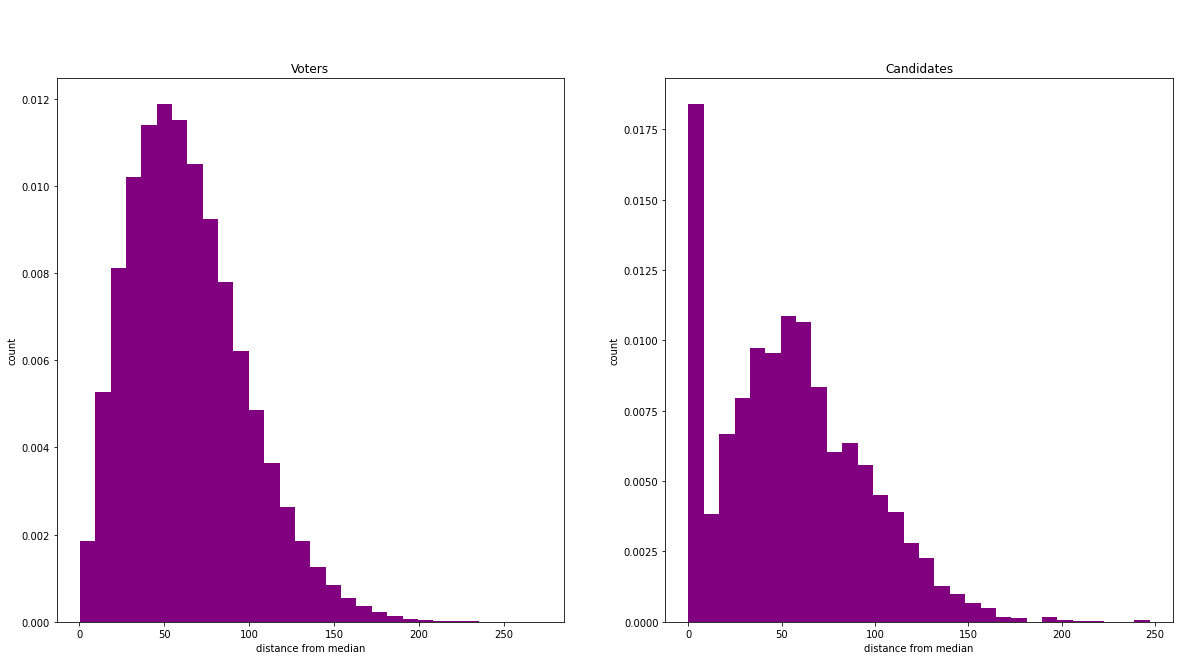

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
fig.suptitle("Distances From Center", fontsize=20, color='black')
fig.set_facecolor("white")


axes[0].hist([all_voters],
         stacked=True,
         density=True,
         bins=30,
         color=["purple"],
         label=["Voters"],
         )
axes[0].title.set_text("Voters")
axes[0].set_xlabel('distance from median')
axes[0].set_ylabel('count')

plt.hist([all_candidates],
         stacked=True,
         density=True,
         bins=30,
         color=["purple"],
         label=["Candidates"],
         )
axes[1].title.set_text("Candidates")
axes[1].set_xlabel('distance from median')
axes[1].set_ylabel('count')

fig.show()

mean distance of winner from center 32.10
mean distance of winner from center 2.31


<ipython-input-18-7dead060e569>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


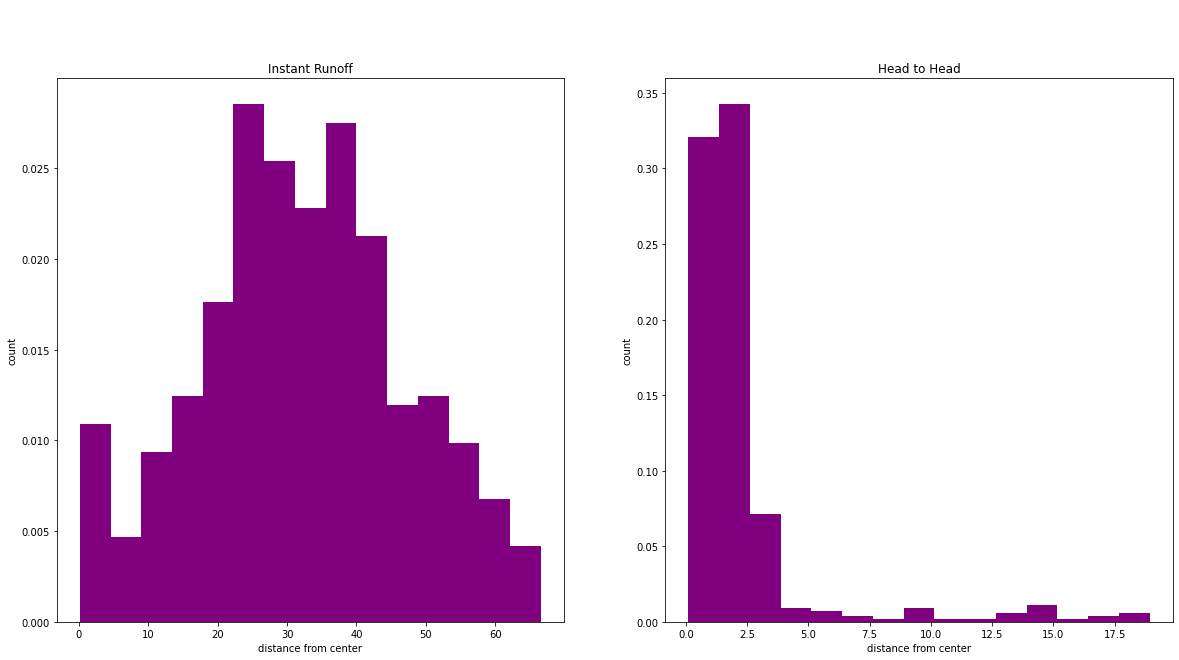

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
fig.suptitle("Distance from Median Voter", fontsize=20, color='black')
fig.set_facecolor("white")

for process_index in range(len(processes)):
    axis = axes[process_index]
    d = get_plot_column(winners, process_index, Independents)
    print("mean distance of winner from center %.2f" % (sum(d) / len(d)))

    axis.hist([d],
             stacked=True,
             density=True,
             bins=15,
             color=["purple"],
             label=["Winners"],
             )
    axis.title.set_text(processes[process_index].name)
    axis.set_xlabel('distance from center')
    axis.set_ylabel('count')

fig.show()


In [ ]:
def build_candidate_input_vec(candidates: List[Candidate], field_width: int) -> np.ndarray:
    result = np.zeros((1, field_width), dtype=float)
    for c in candidates:
        i = int(field_width * (c.ideology + 100 )/200)
        result[0, i] += 1

    return result
